In [1]:
import Pkg

Pkg.add("Interpolations")
Pkg.add("Plots")
Pkg.add("PyCall")
Pkg.add("OrdinaryDiffEq")
Pkg.add("YAML")
Pkg.add("DelimitedFiles")
Pkg.add("CSV")

using Interpolations, Plots, PyCall, OrdinaryDiffEq, YAML, DelimitedFiles, CSV
ct = pyimport("cantera")

#ENV["PYTHON"] = "/opt/conda/envs/lae2020/bin/python"
#Pkg.build("PyCall")

   Updating registry at `~/.julia/registries/General`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Pr

PyObject <module 'cantera' from '/opt/conda/envs/lae2020/lib/python3.8/site-packages/cantera/__init__.py'>

In [2]:

"Composite type to hold ambient conditions, parameters and initial conditions"
struct AmbientConditions
    "Ambient velocity [m/s]"
    u_a::AbstractFloat
    "Ambient temperature [K]"
    T_a::AbstractFloat
    "Ambient passive tracer mixing ratio"
    χ_a::AbstractFloat
    "Prandtl number"
    Pr::AbstractFloat
    "Lewis number"
    Le::AbstractFloat
    "Specific gas constant of air [J/kg]"
    R::AbstractFloat
    "Ambient pressure [Pa]"
    p::AbstractFloat
    "Initial temperature [K]"
    T0::AbstractFloat
    "Initial velocity"
    u0::AbstractFloat
    "Initial passive tracer mixing ratio"
    χ0::AbstractFloat
end

"""
    second_order_central(x, i, Δ)
Computes the second order central difference approximation to the second
derivative of the variable x w.r.t. its discretization dimension (e.g. x is
the state, and its entries x[i] are the values for different radial dimensions)
using the step size Δ, at location i.
# Inputs
- `x` State vector
- `i` Index to compute second order difference for 
- 'Δ' The spacing between the vector elements
"""
function second_order_central(x::AbstractVector, i::Integer, Δ::AbstractFloat)
    return ((x[i+1] - 2 * x[i] + x[i-1])/Δ^2)
end

"""
    construct_rhs(u, T, y, Δψ, Δϕ, ambient; χ=nothing)
Constructs the right-hand-side vector for the system `Ax=b` resulting
from applying the Crank-Nicholson scheme to the governing equations.
# Inputs 
- `u` axial velocities
- `T` temperature
- `y` y-locations of grid points 
- `Δψ` Spacing between grid points in ϕ-ψ space
- `Δϕ` Step size in ϕ-ψ space
- `ambient` Ambient conditions
- `χ` Mixing ratio of passive tracer
"""
function construct_rhs(u::AbstractVector, T::AbstractVector, y::AbstractVector,
     Δψ::AbstractVector, Δϕ::AbstractFloat, ambient::AmbientConditions;
    χ::AbstractVector=nothing)

    if χ !== nothing
        b = zeros(size(u)[1] + size(T)[1] + size(χ)[1])
        include_χ = true 
    else
        b = zeros(size(u)[1] + size(T)[1])
        include_χ = false 
    end

    ## Boundary conditions

    # Neumann conditions at y=0
    b[1] = 0.
    b[size(u)[1] + 1] = 0.0

    # Dirichlet conditions at y -> infinity 
    b[size(u)[1]] = ambient.u_a 
    b[size(u)[1] + size(T)[1]] = ambient.T_a

    # Definition for convenience 
    λ = ambient.u0 / ((ambient.R/ambient.p)^2 * ambient.T0^2) 
    Le = ambient.Le 

    # Loop through b 
    for i=2:size(u)[1]-1
        b[i] = u[i]/Δϕ +  0.5 * λ * y[i]^2 * second_order_central(u, i, Δψ[i])
        b[i+size(u)[1]] = ( T[i]/Δϕ + 0.5 * λ * y[i]^2 
                    * second_order_central(T, i, Δψ[i]) / ambient.Pr )
    end

    if include_χ
        for i=2:size(u)[1]-1
            b[i+2*size(u)[1]] = (χ[i]/Δϕ +  Le * 0.5 * λ * y[i]^2
             * second_order_central(χ, i, Δψ[i]) / ambient.Pr )
        end
        b[size(u)[1] + size(T)[1] + 1] = 0.0
        b[end] = ambient.χ_a
    end

    return b
end

"""
    construct_tridiagonal_matrix(n, Δψ, Δϕ, y, ambient; include_χ=false)
Constructs the matrix `A` for the system `Ax=b` resulting
from applying the Crank-Nicholson scheme to the governing equations.
# Inputs 
- `n` Number of grid points in radial direction
- `Δψ` Spacing between grid points in ϕ-ψ space
- `Δϕ` Step size in ϕ-ψ space
- `y` y-locations of grid points 
- `ambient` Ambient conditions
- `include_χ` indicates if passive tracer is simulated as well
"""
function construct_tridiagonal_matrix(n::Integer, Δψ::AbstractVector,
    Δϕ::AbstractFloat, y::AbstractVector, ambient::AmbientConditions;
    include_χ::Bool=false) 

    if include_χ
        A = zeros((3*n, 3*n))
    else
        A = zeros((2*n, 2*n))
    end
    ## Boundary conditions 

    # Neumann conditions at y=0
    A[1, 1] = (-1/(Δψ[1]))
    A[1, 2] =  1/(Δψ[1])
    A[n+1, n+1] = -1/Δψ[1]
    A[n+1, n+2] =  1/Δψ[1] 

    # Dirichlet conditions at y -> infinity 
    A[n,n] = 1.0 
    A[2*n,2*n] = 1.0

    # Definition for convenience 
    λ = ambient.u0 / ((ambient.R/ambient.p)^2 * ambient.T0^2) 
    
    Pr = ambient.Pr
    Le = ambient.Le 
    # Loop through matrix 
    for i=2:n-1 

        # For u 
        A[i,i] = 1/Δϕ  + λ * y[i]^2 /(Δψ[i]^2)
        A[i, i-1] = - λ * y[i]^2 / (2 * Δψ[i]^2)
        A[i, i+1] = - λ * y[i]^2 / (2 * Δψ[i]^2)

        # For T 
        j = i + n
        A[j, j] = 1/Δϕ  + λ * y[i]^2 / (Pr * Δψ[i]^2)
        A[j, j-1] = - λ * y[i]^2 / (2 * Pr * Δψ[i]^2)
        A[j, j+1] = - λ * y[i]^2 / (2 * Pr * Δψ[i]^2)
    end
    
    if include_χ
        A[2*n+1:end, 2*n+1:end] = Le .* A[n+1:2*n, n+1:2*n]
        A[2*n+1, 2*n+1] = -1/Δψ[1]
        A[2*n+1, 2*n+2] =  1/Δψ[1]
        A[3*n, 3*n] = 1.0
    end

    return A
end

"""
    compute_y(u, T, Δψ, R, p)
Computes y locations corresponding to particular states, based on the 
grid spacing in ϕ-ψ space. 
# Inputs 
- `u` axial velocities
- `T` temperature
- `Δψ` Spacing in ϕ-ψ space
- `R` Specific gas constant for air in J/kg
- `p` Ambient pressure in Pa
"""
function compute_y(u::AbstractVector, T::AbstractVector, Δψ::AbstractVector,
    R::AbstractFloat, p::AbstractFloat)
    return (2*cumsum((R/p)*T ./ u) .* Δψ).^0.5
end

"""
   compute_x(ϵ, Δϕ)
Computes x locations of the grid based on turbulent mixing coefficient ϵ
and step sizes Δϕ
# Inputs 
- `ϵ` Values of the turbulent mixing coefficient
- `Δϕ` Step sizes
"""
function compute_x(ϵ::AbstractVector, Δϕ::AbstractVector)
    x = zeros(size(ϵ))
    x[2:end] = cumsum(Δϕ[1:end-1] ./ ϵ[1:end-1])
    return x 
end

"""
    compute_ψ(u, T, y, p, R)
Computes the transformed coordinate ψ based on the state and y locations.
# Inputs
- `u` axial velocities
- `T` temperature
- `y` y-locations of grid points 
- `R` Specific gas constant for air in J/kg
- `p` Ambient pressure in Pa
"""
function compute_ψ(u::AbstractVector, T::AbstractVector, y::AbstractVector,
    p::AbstractFloat, R::AbstractFloat)
    return cumsum(p./(R*T) .* (y[2:end] .- y[1:end-1]) .* u)
end

"""
    get_ϵ(κ, u, y)
Computes the turbulent mixng coefficient based on current velocity profile.
# Inputs
- `κ` Empirical parameter
- `u` axial velocities
- `y` y-locations of grid points 
"""
function get_ϵ(κ::AbstractFloat, u::AbstractVector, y::AbstractVector)
    # First find the half-width 
    fractional_change = (u .- u[end])./(u[1] - u[end])
    idx = argmin(abs.(fractional_change .- 0.5))
    half_width = y[idx] 
    return κ * (u[1] - u[end]) * half_width
end

"""
    solve_exhaust_flow(u_init, T_init, ambient, n, Δϕ, Δψ; χ_init=nothing)
Solves for the velocity, temperature and optionally passive tracer profiles
within an aircraft engine exhaust jet.
# Inputs
- `u_init` Initial velocity profile
- `T_init` Initial temperature profile
- `ambient` AmbientConditions struct
- `n` Number of grid points in the radial direction
- `Δϕ` Grid spacing in ϕ-ψ space.
- `Δψ` Grid spacing in ϕ-ψ space.
- `χ_init` Initial passive tracer profile.
"""
function solve_exhaust_flow(u_init::AbstractVector, T_init::AbstractVector,
    ambient::AmbientConditions, n::Integer, Δϕ::AbstractVector, 
    Δψ::AbstractVector; χ_init::AbstractVector=nothing)
    
    u_mem = zeros((size(u_init)[1], n))
    T_mem = zeros((size(u_init)[1], n))
    y_mem = zeros((size(u_init)[1], n))
    u_mem[:,1] = u_init
    T_mem[:,1] = T_init
    ϵ = zeros(n)

    include_χ = false 
    if χ_init !== nothing
        include_χ = true
        χ_mem = zeros((size(χ_init)[1], n))
        χ_mem[:,1] = χ_init
    end

    @inbounds for i=1:n-1
        y_mem[:,i] = compute_y(@view(u_mem[:,i]), @view(T_mem[:,i]), Δψ, ambient.R, ambient.p)
        
        if include_χ
            A = construct_tridiagonal_matrix(size(u_init)[1], Δψ, Δϕ[i],
                    @view(y_mem[:,i]), ambient, include_χ=include_χ)
            b = construct_rhs(@view(u_mem[:,i]), @view(T_mem[:,i]),
                    @view(y_mem[:,i]), Δψ, Δϕ[i], ambient, χ=@view(χ_mem[:,i]))
            sol = A\b
            u_mem[:, i+1] = sol[1:size(u_init)[1]]
            T_mem[:, i+1] = sol[size(u_init)[1]+1:size(u_init)[1] + size(T_init)[1]]
            χ_mem[:, i+1] = sol[size(u_init)[1]+size(T_init)[1] + 1:end]
        else
            A = construct_tridiagonal_matrix(size(u_init)[1], Δψ, Δϕ[i], @view(y_mem[:,i]), ambient)
            b = construct_rhs(@view(u_mem[:,i]), @view(T_mem[:,i]), @view(y_mem[:,i]), Δψ, Δϕ[i], ambient)
            sol = A\b 
            u_mem[:, i+1] = sol[1:size(u_init)[1]]
            T_mem[:, i+1] = sol[size(u_init)[1]+1:end]
        end
        ϵ[i] = get_ϵ(0.02, @view(u_mem[:,i]), @view(y_mem[:,i]))
    end

    x = compute_x(ϵ, Δϕ)
    if include_χ
        return x, y_mem, u_mem, T_mem, χ_mem, ϵ
    else
        return x, y_mem, u_mem, T_mem 
    end
end

"""
    regrid_solution(x, y, u, T, χ, y_spacing)
Maps back solution from a grid in ϕ-ψ space to a grid in x-y space.
# Inputs
- `x` x coordinates corresponding to the grid
- `y` y coordinates corresponding to the grid
- `u` Velocity values of solution
- `T` Temperature values of solution
- `y_spacing` Desired spacing in `y` direction for output grid
"""
function regrid_solution(x::AbstractVector, y::AbstractMatrix, u::AbstractMatrix,
    T::AbstractMatrix, χ::AbstractMatrix, y_spacing::AbstractFloat)

    yy = 0:y_spacing:maximum(y)

    u_gridded = zeros((size(yy)[1], size(x)[1]))
    T_gridded = zeros((size(yy)[1], size(x)[1]))
    χ_gridded = zeros((size(yy)[1]), size(x)[1])

    for j=1:size(x)[1]
        u_interp_extrap = LinearInterpolation(y[:,j], u[:,j], extrapolation_bc=Line())
        u_gridded[:,j] = u_interp_extrap(yy)
        T_interp_extrap = LinearInterpolation(y[:,j], T[:,j], extrapolation_bc=Line())
        T_gridded[:,j] = T_interp_extrap(yy)
        χ_interp_extrap = LinearInterpolation(y[:,j], χ[:,j], extrapolation_bc=Line())
        χ_gridded[:,j] = χ_interp_extrap(yy)
    end

    return x, yy, u_gridded, T_gridded, χ_gridded
end

function show_profiles(x, y, var, cols)
    labels = ["x = $xx m" for xx in x[cols]]
    plot(var[:,cols], y[:,cols], dpi=300, label=permutedims(labels))
end

"""
    plot_heatmap(x, y, var, xlabel, ylabel, clabel, colormap)
Plots gridded solution. 
# Inputs
- `x` x location of grid points
- `y` y location of grid points
- `var` Solution variable values at grid points
- `xlabel` Label for horizontal axis
- `ylabel` Label for vertical axis
- `clabel` Label for colormap
- `colormap` Colormap to use (e.g. :viridis)
"""
function plot_heatmap(x, y, var, xlabel, ylabel, clabel, colormap)
    # This is kind of hard-coded, to avoid any issues with the first entry of
    # `x` which typically is zero. 
    # If you use more horizontal grid points, the value `22` doesn't make much
    # sense either
    heatmap(log10.(x[2:22]), 10. .* range(0, stop=1, length=size(y)[1]), clim = (0,Inf),
     var[:,2:22], colorbar_title=clabel, size = (700, 500), dpi=300, c=colormap)
    xlabel!(xlabel)
    ylabel!(ylabel)
    xticks!([-2, -1, 0, 1, 2, 3], ["0.01", "0.1", "1", "10", "100", "1000"])
end

plot_heatmap

In [3]:
struct AmbientConditionsχ
    "Ambient velocity [m/s]"
    u_a::AbstractFloat
    "Ambient temperature [K]"
    T_a::AbstractFloat
    "Ambient passive tracer mixing ratio"
    χ_a::Array
    "Prandtl number"
    Pr::AbstractFloat
    "Lewis number"
    Le::AbstractFloat
    "Specific gas constant of air [J/kg]"
    R::AbstractFloat
    "Ambient pressure [Pa]"
    p::AbstractFloat
    "Initial temperature [K]"
    T0::AbstractFloat
    "Initial velocity"
    u0::AbstractFloat
    "Initial passive tracer mixing ratio"
    χ0::Array
end


function solve_reaction(χ_h0, T, Δϕ, ϵ, u, gas, j) #there is O2 and CO where it shouldnt be... 
    #temp drops but should have ambient amounts instead of initial amounts
    P = 101325 #Pa
    ω = zeros(size(χ_h0))
    reactor = ct.IdealGasConstPressureReactor(gas)  
    
    #FOR NO REACTIONS
    #gas.set_multiplier(0)
    
    for l = 1:50
        for k = 1:53
            if χ_h0[l,k] < 0
                println("negative species input at y=", l, " X=", k)
            end
        end
    end
    
    for i=1:length(χ_h0[:,1]) #index through all "y"s
        
        try
            gas.TPX = T[i], P, χ_h0[i,:] #GO THROUGH TO SEE IF SETTING AND UPDATING GAS CORRECTLY
        catch
           println(i)
           print(gas.report())
        end

        reactor.syncState()
        reactorNet = ct.ReactorNet([reactor])
        
        t_final = Δϕ/(u[i]*abs(ϵ))
        t = 0
        
        reactorNet.advance(t_final, apply_limit=false)

        χ_1[i,:] = 10^6 .*reactor.thermo.X #mole fraction to ppm state.X[len,:] 10^9 #kmol/m^3s, assume 1 m^3, to ppm #rates for specific y (i) and all species UNITS
        
    end
    return χ_1 #for all y and all species [50,n_species]

end

function construct_tridiagonal_matrix_χ(n::Integer, Δψ::AbstractVector,
    Δϕ::AbstractFloat, y::AbstractVector, ambient::AmbientConditionsχ) 

    A = zeros((n, n))

    ## Boundary conditions 
    # Neumann conditions at y=0 #change
    A[1, 1] = -1/(Δψ[1])
    A[1, 2] =  1/(Δψ[1])

    # Dirichlet conditions at y -> infinity #change
    A[n,n] = 1.0 

    # Definition for convenience
    Pr = ambient.Pr
    Le = ambient.Le 
    λ = (Le/Pr)*((ambient.u0*ambient.p^2)/((ambient.R*ambient.T0)^2))
    
    # Loop through matrix 
    for j=2:n-1 
        # For χ
        A[j, j] = 1/Δϕ  + λ * y[j]^2 * 2 / (Δψ[j]^2)
        A[j, j-1] = - λ * y[j]^2 / (Δψ[j]^2)
        A[j, j+1] = - λ * y[j]^2 / (Δψ[j]^2)
    end
    return A
end

function construct_rhs_χ(u, T, y, Δψ, Δϕ, ambient::AmbientConditionsχ, χ, j)

    b = zeros(size(χ)[1])

    ## Boundary conditions
    # Neumann conditions at y=0 #change
    b[1] = 0.

    # Dirichlet conditions at y -> infinity #change
    b[size(χ)[1]] = ambient.χ_a[j]

    # Definition for convenience 
    Pr = ambient.Pr
    Le = ambient.Le 
    λ = (Le/Pr)*((ambient.u0*ambient.p^2)/((ambient.R*ambient.T0)^2))

    # Loop through b 
    #print(size(χ)[1])
    for i=2:size(χ)[1]-1
        b[i] = χ[i]/Δϕ + λ * y[i]^2 * second_order_central(χ, i, Δψ[i])
        #took out 0.5 factor on lambda (not 100% sure why was there) ^^^
    end

    return b
end

function solve_exhaust_flow_χ(u_mem, T_mem, ambient::AmbientConditionsχ, n::Integer, 
        Δϕ,  Δψ::AbstractVector, χ_init, i, j)
   
    y_mem = zeros(size(u_mem))
    
    χ_mem = χ_init
    
    y_mem = compute_y(u_mem, T_mem, Δψ, ambient.R, ambient.p)

    A = construct_tridiagonal_matrix_χ(size(u_mem)[1], Δψ, Δϕ, y_mem, ambient)
    #display(A)
    b = construct_rhs_χ(u_mem, T_mem, y_mem, Δψ, Δϕ, ambient, χ_mem, j)

    sol = A\b
    
    χ_mem = sol
    
    return χ_mem
end

solve_exhaust_flow_χ (generic function with 1 method)

In [16]:
### IMPORT SPECIES NAMES FROM MECHANISM ###
#gri30_species = YAML.load_file("gri30_julia.yaml")
#gri30_species = collect(keys(gri30_species))
#n_species = length(gri30_species) #for gri30
#print(n_species)
#Assign each species to an integer corresponding to its mechanism index
#d = 1
#while d <= n_species
#    string2var(gri30_species[d],d)
#    d = d+1
#end
#print(O2)
n_species =53
### CHOOSE ALTITUDE [m] ###
h = 20000
h_string = string(h)

### IMPORT SHOCK EXIT CONDITIONS ###
#Load YAML file to save shock
dictionary = YAML.load_file("rockettests/"*h_string*"m/"*h_string*"_altitude.yaml")


u0 = dictionary[27]["Shocks Exit Velocity [m/s]"][1] #initial plume velocity
T0 = dictionary[25]["Shocks Exit Temperature [K]"][1] #initial plume temperature
χ0 = 4.e4 #tracer species
p = dictionary[1]["Pressure [Pa]"][1]
u_a = 1E-19*h^5 - 1E-14*h^4 + 4E-10*h^3 - 7E-06*h^2 + 0.0659*h + 53.792 #curve fit #a = ambient vel [m/s] (speed of rocket) UPDATE 
T_a = dictionary[1]["Temperature [K]"][1]
χ_a = 70. #passive tracer mixing ratio [ppm]

### CALCULATE VELOCITY AND TEMPERATURE FIELDS (VIN) ###
n = 100 #n steps in x dir
Δϕ = 0.001 * ones(n) #step size in phi
for i=2:n
    Δϕ[i] = 2*Δϕ[i-1] #double step size each step forward
end
Δψ = 0.5*ones(50) #50 vertical grid points
for i=2:50
    Δψ[i] = 1.1*Δψ[i-1] #enlarge with each step by 1.1
end

Pr = 1. #prandtl number
Le = 1.
u_init = u0 .* ones(50)
T_init = T0 .* ones(50)
χ_init = χ0 .* ones(50)

R = 287.
y_init = compute_y(u_init, T_init, Δψ, R, p)

#Geometry of plume
u_init[y_init .> 0.445] .= u_a
T_init[y_init .> 0.445] .= T_a
χ_init[y_init .> 0.445] .= χ_a

ambient = AmbientConditions(u_a, T_a, χ_a, 1., 1., R, p, T0, u0, χ0);

#Solve for T and u at all steps 
x, y, u, T, χ_vin, ϵ = solve_exhaust_flow(u_init, T_init, ambient, n, Δϕ, Δψ, χ_init=χ_init)

started solver :)
Splitting complete


In [ ]:
### COMPUTE MOLE FRACTIONS IN PLUME ###
#O2 and CO
#ppm must sum to a million

#Redefine species initial conditions for multiple species
χ_a = zeros(n_species)

#add iimport of species here !!!!!!!!!!!!!!!!!!
χ_a[48] = dictionary[27]["Shocks Exit Velocity [m/s]"][1] #ppm N2
χ_a[4] = 209445 #ppm O2
χ_a[49] = 9339 #ppm Ar
χ_a[16] = 426 #ppm CO2

χ0 = zeros(n_species)
#From nozzle exit (update with nozzle exit)
χ0[1] = 0.0035593*10^6 #initial ppm H2
χ0[2] = 0.10857*10^6 #initial ppm H
χ0[3] = 0.74269*10^6 #initial ppm O
χ0[4] = 0.097942*10^6 #initial ppm O2
χ0[5] = 0.045682*10^6 #initial ppm OH
χ0[6] = 0.001399*10^6 #initial ppm H2O
χ0[7] = 0.00015422*10^6 #initial ppm HO2
χ0[8] = 0.00000080817*10^6 #initial ppm H2O2

χ_init = zeros(50,n_species)

i=y_init .>= 0.445
for j=1:length(i)
    if i[j] == 0
        χ_init[j,1] = χ0[1] #ppm H2
        χ_init[j,6] = χ0[6] #ppm H2O
        χ_init[j,4] = χ0[4] #ppm O2
    else
        χ_init[j,48] = χ_a[48]
        χ_init[j,4] = χ_a[4] 
        χ_init[j,49] = χ_a[49]
        χ_init[j,16] = χ_a[16]
    end
end

ambient = AmbientConditionsχ(u_a, T_a, χ_a, 1., 1., R, p, T0, u0, χ0)

χ = zeros(length(χ_vin[:,1]), length(χ_vin[1,:]), n_species) #[y,x,species]

χ[:,1,:] =χ_init #first x value (all y and x)
χ_h0 = zeros(size(χ_init))
χ_1 = zeros(size(χ_init))
ω = zeros(size(χ_init))
gas = ct.Solution("gri30.yaml")

println("started solver :)")

for i=1:n-1 #x 
    for j=1:n_species #species
        #calculate f0 at half step 0.5*Δϕ (x)
        χ_h0[:,j] = solve_exhaust_flow_χ(u[:,i], T[:,i], ambient, n, 0.5*Δϕ[i], Δψ, χ[:,i,j], i, j)
        
        for n = 1:length(χ_h0[:,j])
            if χ_h0[n,j] < 0
                χ_h0[n,j] = 0
            end
        end
    end
    
    χ_1 = solve_reaction(χ_h0, T[:,i], Δϕ[i], ϵ[i], u[:,i], gas, i)

    for j=1:n_species-1 #species
        #calculate f0 at full step Δϕ
        χ[:,i+1,j] = solve_exhaust_flow_χ(u[:,i], T[:,i], ambient, n, 0.5*Δϕ[i], Δψ, χ_1[:,j], i, j)
        
        k = i+1
        for n = 1:length(χ[:,i+1,j])
            if χ[n,k,j] < 0 || χ[n,k,j] == NaN
                χ[n,k,j] = 0
            end
        end
    end
    
    i = i+1  
end

#for i=1:n-1 #x 
#    for j=1:n_species
#        for k = 1:length(χ[:,1,1])
#            if χ[k,i,j] < 0 || χ[k,i,j] == NaN
#            χ[n,k,j] = 0
#            end
#        end
#    end
#end
    
println("Splitting complete")

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
└ @ Interpolations /home/chinahg/.julia/packages/Interpolations/Glp9h/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
└ @ Interpolations /home/chinahg/.julia/packages/Interpolations/Glp9h/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were ded

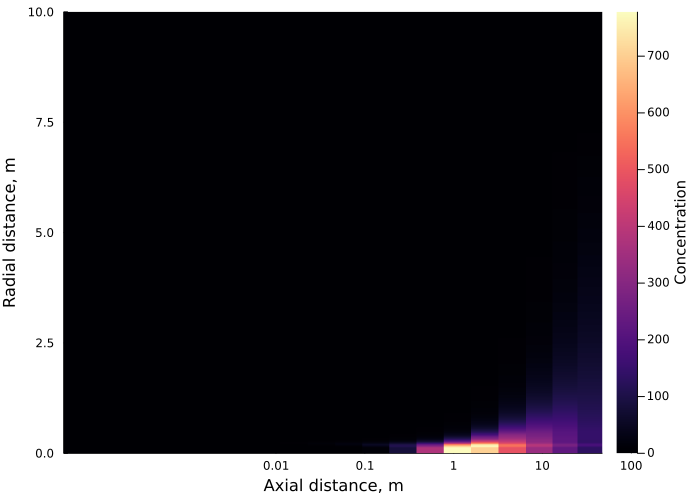

In [17]:
#REGRID SOLUTION
xx, yy, u_g, T_g, χ_gNO =  regrid_solution(x, y, u, T, χ[:,:,36], 0.01)
plot_heatmap(xx, yy, χ_gNO, "Axial distance, m", "Radial distance, m","Concentration", :magma)

In [12]:
macro bash_str(s) open(`bash`,"w",stdout) do io; print(io, s); end; end

@bash_str (macro with 1 method)

In [19]:
bash"
git commit -m "fixed plotting error, add initial concentrations next"
"

LoadError: [91msyntax: extra token "plotting" after end of expression[39m